In [1]:
import numpy as np
import pandas as pd
import os
from Bio import SeqIO
import itertools
from typing import List, Tuple
import string
from pathlib import Path
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [2]:
os.chdir("../../../")
os.getcwd()

'/lustre/eaglefs/projects/robustmicrob/jlaw/projects/prot_stability_engineering'

### Load and combine the ph range and ph opt datasets
1. Brenda ph range
2. E coli manual parsing
3. Brenda ph opt
4. Uniprot ph opt & range
5. TODO Brenda and Uniprot ph stability (?)

In [3]:
def check_ph_act(df):
    """ check to make sure the ph and activity values are within the expected range
    """
    out_of_range = df[(df.ph > 13) | (df.ph < 1) | (df.activity > 1) | (df.activity < 0)]
    print(f"{len(out_of_range) = }")
    if len(out_of_range) > 0:
        print(out_of_range)

In [4]:
inputs_dir = "inputs/brenda"

### Load the Brenda pH range data

In [5]:
# load the pH range and opt values
data_file = Path(inputs_dir, "ph_range/20230907_ph_range_wrxn_type.csv")
print(data_file)
data = pd.read_csv(data_file, index_col=0)
print(len(data))

act_file = Path(inputs_dir, "ph_range/20230907_ph_range_processed_act_wopt.csv")
print(act_file)
data_act = pd.read_csv(act_file)
print(len(data_act))
data_act = data_act[data_act.exp_index.isin(data.index)]
data_act['uniprot_id'] = data_act.exp_index.apply(lambda x: data.loc[x].uniprot_id)
print(len(data_act))
data_act.head(2)

inputs/brenda/ph_range/20230907_ph_range_wrxn_type.csv
3158
inputs/brenda/ph_range/20230907_ph_range_processed_act_wopt.csv
9440
9383


,exp_index,ph,activity,note,ph_range_comment,uniprot_id
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46


In [6]:
check_ph_act(data_act)

len(out_of_range) = 2
      exp_index   ph  activity                                   note  \
7212       4912  6.0       5.0  at pH 4.is about 2% of that at pH 7.4   
7214       4912  9.0       5.0  at pH 4.is about 2% of that at pH 7.4   

                                       ph_range_comment uniprot_id  
7212  at pH 4.5 the activity is about 2% of that at ...     P00571  
7214  at pH 4.5 the activity is about 2% of that at ...     P00571  


In [7]:
# drop this exp. Looks like it was parsed wrong
data = data[data.index != 4912]
data_act = data_act[data_act.exp_index != 4912]

In [8]:
check_ph_act(data_act)

len(out_of_range) = 0


In [9]:
data_act.uniprot_id.value_counts()

Q6LXQ3    34
B0L0Y4    24
A1YLF2    24
A1YLF1    24
Q5LS57    24
          ..
Q0V8L2     1
A7YWM1     1
Q60136     1
Q9RKU9     1
Q8U0A9     1
Name: uniprot_id, Length: 2566, dtype: int64

### Load the manual E coli dataset

In [10]:
# also load the manual E coli dataset
data_file = Path(inputs_dir, "ph_range/ecoli/20230712_ph_curve_data_redox_ann.csv")
print(data_file)
data_ecoli = pd.read_csv(data_file, index_col=0)
print(len(data_ecoli))

act_file = Path(inputs_dir, "ph_range/ecoli/20230712_ph_curve_data_processed_activities.csv")
print(act_file)
data_act_ecoli = pd.read_csv(act_file)
data_act_ecoli['uniprot_id'] = data_act_ecoli.exp_index.apply(lambda x: data_ecoli.loc[x].uniprot_id)
print(len(data_act_ecoli))
data_act_ecoli.head(2)

inputs/brenda/ph_range/ecoli/20230712_ph_curve_data_redox_ann.csv
282
inputs/brenda/ph_range/ecoli/20230712_ph_curve_data_processed_activities.csv
3165


,exp_index,pH,activity,uniprot_id
0,0,7.2,0.012428,P21515
1,0,7.5,0.090313,P21515


In [11]:
data_act_ecoli.uniprot_id.value_counts()

P25524    96
P19926    84
P06721    70
P00864    53
P10902    53
          ..
P17444     5
P37197     5
P0A9T0     4
P0A725     3
P45568     2
Name: uniprot_id, Length: 195, dtype: int64

In [22]:
data_act_ecoli['note'] = 'ecoli_man'
data_act_ecoli.rename(columns={'pH': 'ph'}, inplace=True)
# Fix the activities just below 0
data_act_ecoli.loc[data_act_ecoli.activity < 0, 'activity'] = 0

In [23]:
check_ph_act(data_act_ecoli)

len(out_of_range) = 14
      exp_index    ph  activity uniprot_id       note
75           16   9.1  1.005900     P21514  ecoli_man
196          37  10.0  1.001300     P0A6C5  ecoli_man
197          37  10.5  1.004000     P0A6C5  ecoli_man
205          38   7.0  1.050000     P0A6C5  ecoli_man
335          48   8.0  1.001639     P0AC88  ecoli_man
359          50   7.9  1.001270     P09126  ecoli_man
525          66   7.5  1.001060     P27306  ecoli_man
545          68   5.3  1.002049     P07658  ecoli_man
546          68   5.8  1.016393     P07658  ecoli_man
547          68   6.2  1.057377     P07658  ecoli_man
1180        133   4.5  1.002179     P19926  ecoli_man
1207        134   6.5  1.002179     P19926  ecoli_man
1223        135   3.5  1.002179     P19926  ecoli_man
1783        230  13.5  0.002390     P21179  ecoli_man


In [24]:
data_act_ecoli.head(2)

,exp_index,ph,activity,uniprot_id,note
0,0,7.2,0.012428,P21515,ecoli_man
1,0,7.5,0.090313,P21515,ecoli_man


In [25]:
data_ecoli.head(2)

,gene,uniprot_id,b_number,data_type,mutation,doi,figure_id,time,condition,reaction_note,curator,redox_type
exp_index,,,,,,,,,,,,
0,acpH,P21515,b0404,ph,NaN,10.1016/S0021-9258(18)96069-2,fig4,30,33,NaN,JL,NaN
3,speA,P21170,b2938,ph,wt,10.1016/j.molcatb.2015.06.008,NaN,15,4,NaN,JL,NaN


In [26]:
data_act_ecoli["reaction_type"] = data_act_ecoli.exp_index.apply(
    lambda x: data_ecoli.loc[x].redox_type)
data_act_ecoli.head(2)

,exp_index,ph,activity,uniprot_id,note,reaction_type
0,0,7.2,0.012428,P21515,ecoli_man,NaN
1,0,7.5,0.090313,P21515,ecoli_man,NaN


In [28]:
data_ecoli.redox_type.value_counts()

reduction    7
oxidation    5
Name: redox_type, dtype: int64

### Load the BRENDA pH opt dataset

In [12]:
# load the pHopt values
data_opt = pd.read_csv("inputs/brenda/ph_opt/20230907_ph_opt_no_ph_range_ez_type.csv", index_col=0)
print(data_opt.uniprot_id.nunique(), len(data_opt))
data_opt.head(2)

7660 10683


,ec_num,name,ph_min,ph_max,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor
4701,2.1.1.10,homocysteine S-methyltransferase,7.2,-,-,Brassica oleracea,A4ZGQ8,676384,NaN,NaN,NaN,NaN,NaN,Transferases,one-carbon groups,NaN
4702,2.1.1.10,homocysteine S-methyltransferase,7.5,-,-,Arabidopsis thaliana,Q9M1W4,441387,NaN,NaN,NaN,NaN,NaN,Transferases,one-carbon groups,NaN


In [13]:
# combine the ph_min and ph_max columns 
data_opt_ph_max = data_opt[data_opt.ph_max != "-"]
data_opt_ph_max = data_opt_ph_max.rename(columns={"ph_max": "ph_opt"}).drop(columns="ph_min")
data_opt_ph_min = data_opt.rename(columns={"ph_min": "ph_opt"}).drop(columns="ph_max")
data_opt_2 = pd.concat([data_opt_ph_min, data_opt_ph_max])
data_opt_2 = data_opt_2.sort_values(["ec_num", "organism"])
data_opt_2.head(2)

,ec_num,name,ph_opt,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor
18216,1.1.1.1,alcohol dehydrogenase,8.0,and a second optimum at pH 9.5,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+
18220,1.1.1.1,alcohol dehydrogenase,9.5,and a second optimum at pH 8.0,Drosophila melanogaster,P00334,285619,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+


In [14]:
data_opt_2.uniprot_id.value_counts()

P08659        17
C4TJD2        14
Q5M886        13
Q9NR71        13
Q9Z1M7        12
              ..
A0A286JZ72     1
Q8U1H4         1
B5L0W0         1
K7ZLW6         1
Q0PCR9         1
Name: uniprot_id, Length: 7660, dtype: int64

In [15]:
data_opt_2[data_opt_2.uniprot_id.isin(data_opt_2.uniprot_id.value_counts().head(2).index)]

,ec_num,name,ph_opt,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor
2267,1.13.12.7,firefly luciferase,5.0,red emitted light,Photinus pyralis,P08659,698393,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2268,1.13.12.7,firefly luciferase,5.4,red emitted light,Photinus pyralis,P08659,697221,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2269,1.13.12.7,firefly luciferase,5.5,shift of emission spectra to red region,Photinus pyralis,P08659,696341,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2271,1.13.12.7,firefly luciferase,7.5,yellow-green emitted light,Photinus pyralis,P08659,698393,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2273,1.13.12.7,firefly luciferase,7.5,"pH 7.8, 25°C, wild-type enzyme",Photinus pyralis,P08659,764596,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2274,1.13.12.7,firefly luciferase,7.6,yellow-green emitted light,Photinus pyralis,P08659,697221,NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2277,1.13.12.7,firefly luciferase,7.8,-,Photinus pyralis,P08659,"484842, 484843, 671869, 672684, 686447, 696341...",NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2278,1.13.12.7,firefly luciferase,7.8,-,Photinus pyralis,P08659,"484842, 484843, 671869, 672684, 686447, 696341...",NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2279,1.13.12.7,firefly luciferase,7.8,-,Photinus pyralis,P08659,"484842, 484843, 671869, 672684, 686447, 696341...",NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other
2280,1.13.12.7,firefly luciferase,7.8,-,Photinus pyralis,P08659,"484842, 484843, 671869, 672684, 686447, 696341...",NaN,NaN,NaN,NaN,NaN,Oxidoreductases,oxygenases,other


In [16]:
data_opt_2["ph_opt"] = data_opt_2.ph_opt.astype(float)
data_opt_2["ph_opt"].value_counts()

8.00     1701
7.00     1467
7.50     1362
6.00     1003
8.50      813
         ... 
9.75        1
1.00        1
11.30       1
1.30        1
7.31        1
Name: ph_opt, Length: 114, dtype: int64

In [61]:
df

,ec_num,name,ph_opt,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor
4672,1.8.99.B2,tetrathionate reductase,2.5,-,Acidithiobacillus ferrooxidans,B7J3E3,741675,NaN,reduction,NaN,NaN,NaN,Oxidoreductases,sulfur group of donors,other


In [17]:
# for each uniprot ID and redox_type combo, take the average pH as the optimum
data_opt_mean = []
for cols, df in data_opt_2.groupby(["ec_num", "uniprot_id", "reaction_type"], dropna=False):
    # print(cols, df)
    if len(df) == 1:
        data_opt_mean += [df]
        continue
    ph_min, ph_max = df.ph_opt.min(), df.ph_opt.max()
    df["max_min_diff"] = ph_max - ph_min
    # remove proteins with a ph opt spread > 4 ph
    if abs(ph_max - ph_min) > 4:
        # print(df)
        continue
    ph_mean = df.ph_opt.mean()
    df["ph_opt"] = ph_mean
    data_opt_mean += [df.head(1)]

data_opt_mean = pd.concat(data_opt_mean)
print(len(data_opt_2), len(data_opt_mean))
data_opt_mean.head(2)

13014 8136


,ec_num,name,ph_opt,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor,max_min_diff
59,1.1.1.1,alcohol dehydrogenase,10.0,"glycine–NaOH buffer, highest activity for oxid...",Pyrobaculum calidifontis,A3MVR8,742472,NaN,oxidation,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,NaN
15,1.1.1.1,alcohol dehydrogenase,6.0,"sodium phosphate buffer, highest activity for ...",Pyrobaculum calidifontis,A3MVR8,742472,NaN,reduction,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,NaN


<AxesSubplot: ylabel='Frequency'>

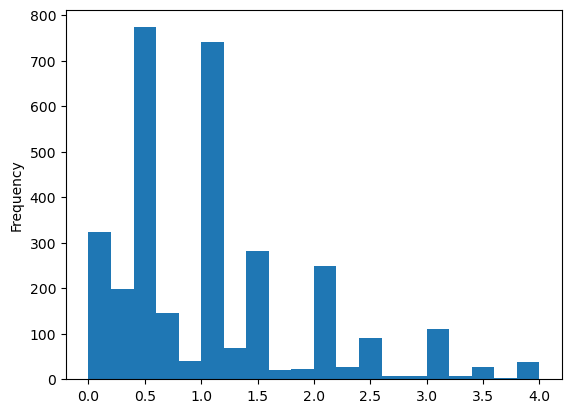

In [19]:
data_opt_mean.max_min_diff.plot.hist(bins=20)

In [20]:
# we already matched the ph_opt data to the ph_range, so just keep the unique uniprot IDs here
data_opt_mean_uniq = data_opt_mean[~data_opt_mean.index.isin(data_act.uniprot_id.unique())]
data_opt_mean_uniq = data_opt_mean_uniq.reset_index()
data_opt_mean_uniq = data_opt_mean_uniq.rename(columns={'ph_opt': 'ph'})
data_opt_mean_uniq['activity'] = 1
print(len(data_opt_mean), len(data_opt_mean_uniq))
data_opt_mean_uniq.head(2)

8136 8136


,index,ec_num,name,ph,comments,organism,uniprot_id,ref,ph_range_ref_match,reaction_type,note,cofactor,substrate,enzyme_type,enzyme_type_sub,acceptor,max_min_diff,activity
0,59,1.1.1.1,alcohol dehydrogenase,10.0,"glycine–NaOH buffer, highest activity for oxid...",Pyrobaculum calidifontis,A3MVR8,742472,NaN,oxidation,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,NaN,1
1,15,1.1.1.1,alcohol dehydrogenase,6.0,"sodium phosphate buffer, highest activity for ...",Pyrobaculum calidifontis,A3MVR8,742472,NaN,reduction,NaN,NaN,NaN,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,NaN,1


In [21]:
check_ph_act(data_opt_mean_uniq)

len(out_of_range) = 0


### Load the Uniprot pH data

In [33]:
# load the pHopt values
data_uniprot = pd.read_csv("inputs/uniprot/parsed/20230922_ph_opt_redox_ann.csv")
print(data_uniprot.uniprot_id.nunique(), len(data_uniprot))
data_uniprot.head(2)

4740 4942


,prot_index,ph,note,ph_dependence,uniprot_id,min_max_diff,activity,reaction_type
0,0,5.5,{ECO:0000269|PubMed:34801773};,Optimum pH is 5.5. {ECO:0000269|PubMed:34801773};,A0A023I7E1,NaN,1.0,NaN
1,4323,4.5,with CMC as substrate. {ECO:0000269|PubMed:335...,Optimum pH is 4.5 with CMC as substrate. {ECO:...,A0A023VXA2,NaN,1.0,NaN


In [34]:
data_uniprot.reaction_type.value_counts()

oxidation    38
reduction    34
Name: reaction_type, dtype: int64

In [44]:
data_uniprot = data_uniprot.rename(columns={"prot_index": "exp_index"})
data_uniprot.head(2)

,exp_index,ph,note,ph_dependence,uniprot_id,min_max_diff,activity,reaction_type
0,0,5.5,{ECO:0000269|PubMed:34801773};,Optimum pH is 5.5. {ECO:0000269|PubMed:34801773};,A0A023I7E1,NaN,1.0,NaN
1,4323,4.5,with CMC as substrate. {ECO:0000269|PubMed:335...,Optimum pH is 4.5 with CMC as substrate. {ECO:...,A0A023VXA2,NaN,1.0,NaN


### Fix the columns before merging

In [30]:
data_act.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,redox_type,enzyme_type,enzyme_type_sub,acceptor
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+


In [31]:
# add the enzyme type columns
ez_cols = ["redox_type", "enzyme_type", "enzyme_type_sub", "acceptor"]
data_act[ez_cols] = data_act.exp_index.apply(
    lambda x: data.loc[x][ez_cols])
data_act = data_act.rename(columns={"redox_type": "reaction_type"})
data_act.head(2)

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor
0,1,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+
1,1,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+


### Merge the datasets together

In [39]:
print(len(data_act), len(data_act_ecoli), len(data_opt_mean_uniq))
print(data_act.uniprot_id.nunique(), 
      data_act_ecoli.uniprot_id.nunique(), 
      data_opt_mean_uniq.uniprot_id.nunique())

9380 3165 8136
2566 195 7622


In [40]:
data_act_merged = pd.concat([data_act, data_act_ecoli, data_opt_mean_uniq], ignore_index=True).reset_index(drop=True)
print(data_act_merged.uniprot_id.nunique(), len(data_act_merged))
data_act_merged.head(2)

10326 20681


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,ec_num,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff
0,1.0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [36]:
out_file = Path(inputs_dir, "20230922_ph_data_merged.csv")
data_act_merged.to_csv(out_file, index=False)

In [41]:
print(len(data_act), len(data_act_ecoli), len(data_opt_mean_uniq), len(data_uniprot))
print(data_act.uniprot_id.nunique(), 
      data_act_ecoli.uniprot_id.nunique(), 
      data_opt_mean_uniq.uniprot_id.nunique(), 
      data_uniprot.uniprot_id.nunique())

9380 3165 8136 4942
2566 195 7622 4740


In [45]:
data_act_merged = pd.concat([data_act, data_act_ecoli, data_opt_mean_uniq, data_uniprot], ignore_index=True).reset_index(drop=True)
print(data_act_merged.uniprot_id.nunique(), len(data_act_merged))
data_act_merged.head(2)

13057 25623


,exp_index,ph,activity,note,ph_range_comment,uniprot_id,reaction_type,enzyme_type,enzyme_type_sub,acceptor,...,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff,ph_dependence,min_max_diff
0,1.0,4.0,0.8,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,7.5,0.6,NaN,"pH 4.0: about 80% of maximal activity, pH 7.5:...",B2KJ46,reduction,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [47]:
data_act_merged_unique = data_act_merged.drop_duplicates(subset=["ph", "activity", "uniprot_id", "reaction_type"])
print(len(data_act_merged_unique))

23379


In [48]:
out_file = Path(inputs_dir, "20230926_ph_data_merged.csv")
data_act_merged.to_csv(out_file, index=False)

### Make sure we have the sequences and embeddings for all

In [87]:
with open(Path(inputs_dir, "uniprot/uniprot_ids.txt"), 'w') as out:
    out.write('\n'.join(data_act_merged.uniprot_id.unique()) + '\n')

I uploaded the uniprot IDs to uniprots ID mapping tool, then used the mapping to download the sequences

In [90]:
idmapping_file = Path(inputs_dir, "uniprot/idmapping_2023_09_22.tsv.gz")
df_idmap = pd.read_table(idmapping_file)
print(len(df_idmap))
df_idmap = df_idmap.rename(columns={"From": "uniprot_id", "Sequence": "sequence"})
df_idmap = df_idmap.dropna(subset="sequence")
print(len(df_idmap))
df_idmap.head(2)

10258
10228


,uniprot_id,Entry,Reviewed,Protein names,Gene Names,Organism,Organism (ID),Length,pH dependence,sequence
0,B2KJ46,B2KJ46,unreviewed,Carbonyl Reductase (EC 1.1.1.-) (S-reductase) ...,SOU1 DQ675534 FOB60_004123,Candida parapsilosis (Yeast),5480.0,279.0,NaN,MGEIESYCNKELGPLPTKAPTLSKNVLDLFSLKGKVASVTGSSGGI...
1,Q4J702,Q4J702,unreviewed,Oxidoreductase (EC 1.-.-.-),Saci_2130,Sulfolobus acidocaldarius (strain ATCC 33909 /...,330779.0,264.0,NaN,MDIDRLFSVKGMNAVVLGASSGIGKAIAEMFSEMGGKVVLSDIDEE...


### Compare with uniprot's ph data
Looks like the data match up pretty well. For A4UHT7, uniprot had the forward and reverse whereas brenda only had the reverse.

In [96]:
print(len(df_idmap.dropna(subset="pH dependence")))
df_idmap.dropna(subset="pH dependence").head(4)[["uniprot_id", "pH dependence"]].values

2124


array([['Q5UY95',
        'BIOPHYSICOCHEMICAL PROPERTIES:  pH dependence: Optimum pH is 8.3. {ECO:0000269|PubMed:15342590};'],
       ['Q2KNL6',
        'BIOPHYSICOCHEMICAL PROPERTIES:  pH dependence: Optimum pH is 9.5. Active from pH 8.5 to 10.0. {ECO:0000269|PubMed:16150417};'],
       ['O75828',
        'BIOPHYSICOCHEMICAL PROPERTIES:  pH dependence: Optimum pH is 5.5-7. {ECO:0000269|PubMed:15537833, ECO:0000269|PubMed:18493841};'],
       ['A4UHT7',
        'BIOPHYSICOCHEMICAL PROPERTIES:  pH dependence: Optimum pH is 6 for the reverse reaction (reduction) with activity decreasing sharply towards pH 4.5 and pH 7.5. Optimum pH is 9.5 for the forward reaction (oxidation) with greatly reduced activity at pH 6. {ECO:0000269|PubMed:17337529, ECO:0000269|PubMed:19648114};']],
      dtype=object)

In [101]:
data_act_merged.head(2).columns

Index(['exp_index', 'ph', 'activity', 'note', 'ph_range_comment', 'uniprot_id',
       'enzyme_type', 'enzyme_type_sub', 'acceptor', 'reaction_type', 'index',
       'ec_num', 'name', 'comments', 'organism', 'ref', 'ph_range_ref_match',
       'cofactor', 'substrate', 'enzyme_type_sub ', 'max_min_diff'],
      dtype='object')

In [102]:
data_act_merged[data_act_merged.uniprot_id.isin(["Q5UY95"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,enzyme_type,enzyme_type_sub,acceptor,reaction_type,...,ec_num,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff
82,48.0,8.3,1.0,-,NaN,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,48.0,9.0,0.5,NaN,more than 50% of maximal activity,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,48.0,7.0,0.5,NaN,more than 50% of maximal activity,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
307,201.0,7.0,0.5,NaN,50% of maximum activity,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
308,201.0,8.3,1.0,presence of 1.5 M KCl,NaN,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
309,202.0,8.3,1.0,presence of 1.5 M KCl,NaN,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
310,202.0,9.0,0.5,NaN,50% of maximum activity,Q5UY95,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [103]:
data_act_merged[data_act_merged.uniprot_id.isin(["Q2KNL6"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,enzyme_type,enzyme_type_sub,acceptor,reaction_type,...,ec_num,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff
91,51.0,8.5,0.72,NaN,over 72% of maximal activity at pH 8.5 and pH ...,Q2KNL6,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
92,51.0,9.5,1.00,-,NaN,Q2KNL6,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93,51.0,10.0,0.72,NaN,over 72% of maximal activity at pH 8.5 and pH ...,Q2KNL6,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,oxidation,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [104]:
data_act_merged[data_act_merged.uniprot_id.isin(["O75828"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,enzyme_type,enzyme_type_sub,acceptor,reaction_type,...,ec_num,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff
94,52.0,4.0,0.15,NaN,15% of maximum activity,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,52.0,5.5,1.00,-,NaN,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
96,52.0,7.0,1.00,-,NaN,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,55.0,8.0,0.35,NaN,35% of maximum activity,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
101,55.0,5.5,1.00,-,NaN,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
102,55.0,7.0,1.00,-,NaN,O75828,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [105]:
data_act_merged[data_act_merged.uniprot_id.isin(["A4UHT7"])]

,exp_index,ph,activity,note,ph_range_comment,uniprot_id,enzyme_type,enzyme_type_sub,acceptor,reaction_type,...,ec_num,name,comments,organism,ref,ph_range_ref_match,cofactor,substrate,enzyme_type_sub,max_min_diff
141,122.0,6.0,0.95,reduction reaction,the enzyme shows a steep decrease by 90% of ac...,A4UHT7,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
142,122.0,4.5,0.10,reduction reaction,the enzyme shows a steep decrease by 90% of ac...,A4UHT7,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
143,122.0,6.0,1.00,reduction reaction,NaN,A4UHT7,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
144,122.0,7.5,0.10,reduction reaction,the enzyme shows a steep decrease by 90% of ac...,A4UHT7,Oxidoreductases,CH-OH group of donors,NAD+ or NADP+,reduction,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
